## Recipe for training on Google ML Engine
This kernel describes how I got Alex Ozerin's kernel (https://www.kaggle.com/alexozerin/end-to-end-baseline-tf-estimator-lb-0-72 ) running on Google ML Engine.

Use this recipe at your own risk !

### create a project on Google Cloud
see https://cloud.google.com/resource-manager/docs/creating-managing-projects
* go to https://console.cloud.google.com/
* from the menu on the right select 'IAM & admin' -> 'Manage resources'
* on the newly opened page, click on 'Create Project'
* choose a project id, in my case I selected kaggle-speech-(number)
* for some reason the new project does not appear immediately in the list of projects on the 'Manage resources' page. Check the notification icon at the top right for completion of  the project creation process.
* make sure the new project is the currently selected one (there is a dropdown menu right of 'Google Cloud Platform' at the top right of the Google cloud console at the top right
* make sure that billing is set up correctly

* install the Google Cloud SDK on your local machine as described here: https://cloud.google.com/sdk/downloads
* initialize the cloud SDK on your local machine (see https://cloud.google.com/sdk/docs/initializing ) by running

```gcloud init```

We'll use the gcloud command to submit jobs to the ML engine at the end.


   


### create a VM for packing train and test data
It turns out that running training on the ~ 65k files is rather slow compared to packing the training data into one single npy file. In this section I describe how I created such a packed file in a virtual machine running on the Google compute engine thereby avoiding uploading several gigabytes of data through my 1 MBit/s ADSL connection.

* see also the documentation here: https://cloud.google.com/compute/docs/instances/create-start-instance
* go to https://cloud.google.com/compute/docs/images#os-compute-support
* go to the table row with 'Ubuntu', click on the Start button on the right in this row.
* on the following page, select 'Ubuntu Xenial 16.04' (make sure that this is a virtual machine and not a container)
* click on 'Launch on Compute Engine'
* on the following page ('VM instances') I selected a virtual machine which can deal with the size of the dataset on disk and in memory:
   * select n1-highmem-2 from the 'machine type' drop down menu. This will give you a machine with two virtual CPUs and 13 GByte memory
   * increase the boot disk size to 25 GByte (we need to store the zipped, unzipped and numpy array files on disk for
the train and test dataset -- one could probably do with 20 GByte or even less but 25 GByte works well)
   * The corresponding section on this page should look as follows:
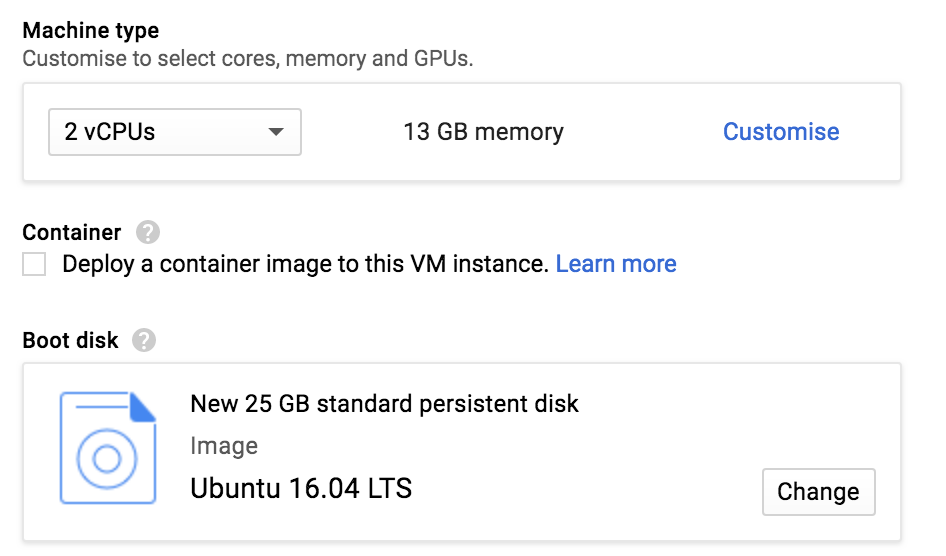
   * ensure that the Zone corresponds to where you want to run on GPUs afterwards (zone starts with us-east1 in my case), You can see which zones have GPUs available here: https://cloud.google.com/compute/docs/gpus/ . You can also see the pricing in different zones here: https://cloud.google.com/compute/pricing#gpus
   * under the 'Access scopes' section, select 'Set access for each API'. A list of dropdown menus appears.
      * In order to grant this VM permission to create buckets as part of your project (see https://stackoverflow.com/a/27298944/288875 and https://cloud.google.com/compute/docs/access/create-enable-service-accounts-for-instances):
      * Set the menu item under 'Storage' to 'Read/Write'. 
       
Once all settings are as desired:
       
* Click the 'Create' button at the bottom of the page.
    
You then should be directed to a page with an overview of the state of your VM instances (https://console.cloud.google.com/compute/instances ) . The newly created instance should have been started automatically.
* login to this vm: click on 'ssh' on the line corresponding to the newly created VM
   * on first attempt I got a message in Chrome that it blocked a popup but on the second attempt
it opened a window in the browser with a console. 

### Download train and test datasets to the new VM and pack them 

In this step we'll download the train and test datasets from Kaggle and pack them into one big 2D matrix for each of the train and test datasets.

* In the shell where you are logged into the VM create a directory (other than /tmp/) to store the Kaggle datasets. In the VM execute the following commands:
   * sudo mkdir /data
   * sudo chown $(whoami) /data
   * cd /data
(make sure NOT to paste the asterisks/bullets at the beginning of the lines into the shell !)

#### Download the Kaggle dataset from the VM
   * The datasets can't simply be downloaded from the command line as they need to be downloaded from within an authenticated session with kaggle.com
   * To get the necessary URL parameters I installed the Chrome extension CurlWget, see https://chrome.google.com/webstore/detail/curlwget/jmocjfidanebdlinpbcdkcmgdifblncg?hl=en
   * Make sure you are logged in on kaggle.com in the browser on your local machine.
   * Navigate to the dataset page on Kaggle: https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/data. 
   * click e.g. on 'train.7z' then click 'Download'. In my case a file/directory chooser dialog opens. Press cancel. If the download starts by itself, cancel it.
    * At the top right I see the 'CurlWget' icon (round yellow icon with a greater than sign). Click on it: you should see a wget command. Make
sure it has the correct type of file you want to download in the command (e.g. 'train.7z'). Copy the entire wget command and paste it into the VM command line.

In my case the command starts with

```wget --header="```

and ends with  

```-O "train.7z" -c```

for the train dataset 

* once the train.7z and test.7z files are downloaded install the 7z utility on the VM and python packages required later.
   * in the VM execute the following commands:

`sudo apt-get install -y p7zip-full python3-numpy python3-scipy python3-pip python-psutil`

`pip3 install --user tqdm`

* then unpack the train and test datasets in the `/data` directory with the following commands:
```7z x train.7z >/dev/null & 7z x test.7z > /dev/null```

(wait until both processes complete, this can take more than one hour)

#### Initialize the gcloud environment and create a storage bucket

* create a storage bucket to download the Kaggle dataset to (see also https://cloud.google.com/compute/docs/disks/gcs-buckets )
    * initialize the glcoud environment on the VM:

```gcloud init```

when asked about the account to use, select the account of the form `<number>-compute@developer.gserviceaccount.com`

When asked about the project id you would like to use, enter the project id (in my case of the form `kaggle-speech-(number)`).

You can ignore warnings about missing permissions to list all available projects.

   * set the environment variable PROJECT_ID in the shell on the VM:

```PROJECT_ID=$(gcloud config list project --format "value(core.project)")```
  
   * select a name for the storage bucket, e.g.

`BUCKET_NAME=${PROJECT_ID}-data`

* set an environment variable for the Google cloud platform region you want to use, in my case this is:

`REGION=us-east1`

   * create the storage bucket:

`gsutil mb -l $REGION gs://$BUCKET_NAME`

#### Pack the train and test data

* get `pack-for-gcp.py` from gist.github.com:
    * In the VM shell execute
    
`wget 'https://gist.githubusercontent.com/andreh7/b444c932b0e6dfda51c2efd19732581c/raw/fb1220c45136a12c9f7530dca27a1cb69863ddf6/pack-for-gcp.py'`
* run pack-for-gcp.py in the directory where you unpacked the train and test datastets (/data), e.g. as follows:

`cd /data`
`python3 pack-for-gcp.py $PWD $PWD`

this will search for the input files in the current working directory and will write out .npy (wave data) and .csv files (file names etc.)  to the current working directory.

#### Copy the packed wave data and meta data to the storage bucket

* execute the following commands in the shell on the VM:
`cd /data`

`gsutil -m cp *.npy *.csv gs://$BUCKET_NAME`

* verify that the files were properly copied to the storage bucket:

`gsutil ls -l gs://$BUCKET_NAME`

you should see three .npy files and three .csv files corresponding to the train, test and noise wave files and associated metadata. The .npy files are several gigabytes in size.

#### shutting down the VM

* Make sure to shut down the virtual machine when you don't need it anymore to avoid unnecessary costs. You may even want to delete it after having run the above commands and don't need it anymore (e.g. if you plan to train your models by submitting jobs from your local machine to ML Engine).

You can shutdown the machine from the web interface https://console.cloud.google.com/compute/instances 
or by doing 

`sudo /sbin/poweroff`

from a shell in the VM (note that when shutting the VM down from the command line it takes some time until the VM status is reflected in the web console application)




   



### Download and run a modified version of Alex Ozerin's baseline estimator

* create an (empty) working directory to run the training from
* create a subdirectory `trainer`
* download the adapted kernel from https://www.kaggle.com/holzner/alex-ozerin-s-estimator-for-google-ml-engine/ 
   * store it as `trainer/task.py` (i.e. in the subdirectory `trainer/`)
* create an empty file `trainer/__init__.py`. On OSX/Linux you can do this from the command line with the command:
`touch trainer/__init__.py`

#### Running training locally for a quick test

* It is recommended to first run the kernel on your local machine before submitting it to Google's ML Engine to see if everything works
   * You'll need a python 2 environment with tensorflow installed. Python 3 is not supported at the moment by the ML Engine as far as I understood.

   *   set a few environment variables (assuming you have a Bourne like shell such as bash or zsh):

```
INDIR=... # relative or absolute path of the location of unpacked train and test data directories
OUTDIR=... # relative or absolute path of directory where to store model checkpoints and test set predictions
```
   * run a abbreviated version of the training:
```
gcloud ml-engine local train \
   --module-name trainer.task \
   --package-path trainer/ \
   --job-dir $OUTDIR \
   -- \
   --indir $INDIR \
   --train-steps 100 \
   --train-steps-per-iteration 10 \
   --eval-steps 1
```
   * This should produce a file `$OUTDIR/submission.csv`
   
#### Submitting a training job to ML Engine
   
   If the above was successful, you can try submitting your job to the ML Engine:
   
```
# name of the bucket you created above, without the gs:// prefix
BUCKET=... 

# region where you created the VM and bucket above (us-east1 in my case)
REGION=... 

# select a scale tier which has GPUs
# see https://cloud.google.com/ml-engine/docs/training-overview
SCALE_TIER=BASIC_GPU

# Create a job id. This must be unique (within your project as far as I understood)
# so including the job creation time is a good choice (assuming you are not
# creating more than one job per second)
# note: no special characters (apart from underscores) allowed in job names
JOB_NAME=job_$(date +%Y_%m_%d_%H%M%S)

# storage location where to store trained model
# files and predictions
# use the input bucket also for writing out submissions
# for simplicity
# (a better design would be to use a separate
#  storage bucket for output)
OUTDIR=gs://$BUCKET/output-$JOB_NAME

# storage location of the packed train and test wav files
# IMPORTANT: do not leave a trailing / here !
# if the bucket file url has another // in it
# the job may NOT find the files !
INDIR=gs://${BUCKET}

echo "test set predictions will be stored in $OUTDIR/submission.csv"

# submit the training and prediction job
gcloud ml-engine jobs submit training $JOB_NAME \
  --region $REGION \
  --scale-tier $SCALE_TIER \
  --module-name trainer.task \
  --package-path trainer/ \
  --runtime-version 1.4 \
  --job-dir $OUTDIR \
  -- \
  --indir $INDIR
  ```

* The above lines are best stored in a single script which can be used to submit jobs after generating a job id with the current timestamp.
* To monitor your job, either use the command printed after job submission which is of the form

`gcloud ml-engine jobs stream-logs $JOBID`

(the exact command is printed by the gcloud command after successful submission). In my case, running the training and test set prediction took about 41 minutes with the default training parameters from Alex' original kernel.
* Alternatively, you can go to the ML engine job overview page here: https://console.cloud.google.com/mlengine/jobs and follow the job's progress by clicking on the 'View logs' item on the line corresponding to your job.
* During training (or after) you can also run tensorboard on your local machine and monitor training progress by passing the Google storage bucket URL as logdir:

`tensorboard --logdir $OUTDIR`

and navigate your browser to http://localhost:6006 . Note that it takes somewhat more time for the dashboard to appear than it does for local directories.

#### Fetch the predicted output

* Once  the job has completed successfully, you can retrieve the submission.csv file from the output storage bucket. To copy it to the current directory on your local machine (assuming you still have the environment variables from above set):

`gsutil cp $OUTDIR/submission.csv $PWD`

* You can list the output directory contents with

`gsutil ls $OUTDIR`

You may want to delete the job output directory when you don't need it anymore to avoid being billed unnecessarily for storage.







   

   

